In [1]:
import torch
import torch.nn as nn
import numpy as np
from torchvision import models, transforms
from scipy.linalg import sqrtm

In [3]:
transform = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Load the pretrained InceptionV3 model
inception_model = models.inception_v3(pretrained=True, transform_input=False)
inception_model.fc = nn.Identity()  # Remove the final classification layer
inception_model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [4]:
def get_activations(images, model, batch_size=32, device="cuda"):
    model = model.to(device)
    n_images = len(images)
    n_batches = (n_images + batch_size - 1) // batch_size
    activations = []

    for i in range(n_batches):
        batch = images[i * batch_size : (i + 1) * batch_size].to(device)
        with torch.no_grad():
            pred = model(batch)
        activations.append(pred.cpu().numpy())

    activations = np.concatenate(activations, axis=0)
    return activations


def calculate_fid(real_activations, generated_activations):
    mu1 = np.mean(real_activations, axis=0)
    sigma1 = np.cov(real_activations, rowvar=False)

    mu2 = np.mean(generated_activations, axis=0)
    sigma2 = np.cov(generated_activations, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid


# Example usage
# real_images and generated_images should be lists of PIL images
def compute_fid(real_images, generated_images, batch_size=32, device="cuda"):
    real_images = [transform(img) for img in real_images]
    generated_images = [transform(img) for img in generated_images]

    real_images = torch.stack(real_images)
    generated_images = torch.stack(generated_images)

    real_activations = get_activations(real_images, inception_model, batch_size, device)
    generated_activations = get_activations(
        generated_images, inception_model, batch_size, device
    )

    fid_score = calculate_fid(real_activations, generated_activations)
    return fid_score

In [16]:
import os
from PIL import Image


def load_images_from_folder(
    folder_path, extensions=[".png", ".jpg", ".jpeg"], quantity=10000
):
    images = []
    for root, _, filenames in os.walk(folder_path):
        for filename in filenames:
            if any(filename.lower().endswith(ext) for ext in extensions):
                img_path = os.path.join(root, filename)
                img = Image.open(img_path).convert("RGB")
                images.append(img)
                if len(images) >= quantity:
                    return images
    return images

In [25]:
images_real = load_images_from_folder("../data/bedroom/")

In [20]:
!pip install diffusers
from diffusers import UNet2DModel

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
model_path = "models/model128x128.pt"
model = UNet2DModel(
    in_channels=3,  # 3 channels for RGB images
    sample_size=64,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(64, 128, 256, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.4 MB/s eta 0:00:00m eta 0:00:0136m0:00:01


/Users/michal/anaconda3/envs/Datascience/lib/python3.11/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 64, ker

In [21]:
from diffusers import DDPMPipeline, DDPMScheduler

scheduler = DDPMScheduler(num_train_timesteps=1000, beta_start=0.001, beta_end=0.02)
pipeline = DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=4).images
ims

  0%|          | 0/1000 [00:00<?, ?it/s]

[<PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>,
 <PIL.Image.Image image mode=RGB size=64x64>]

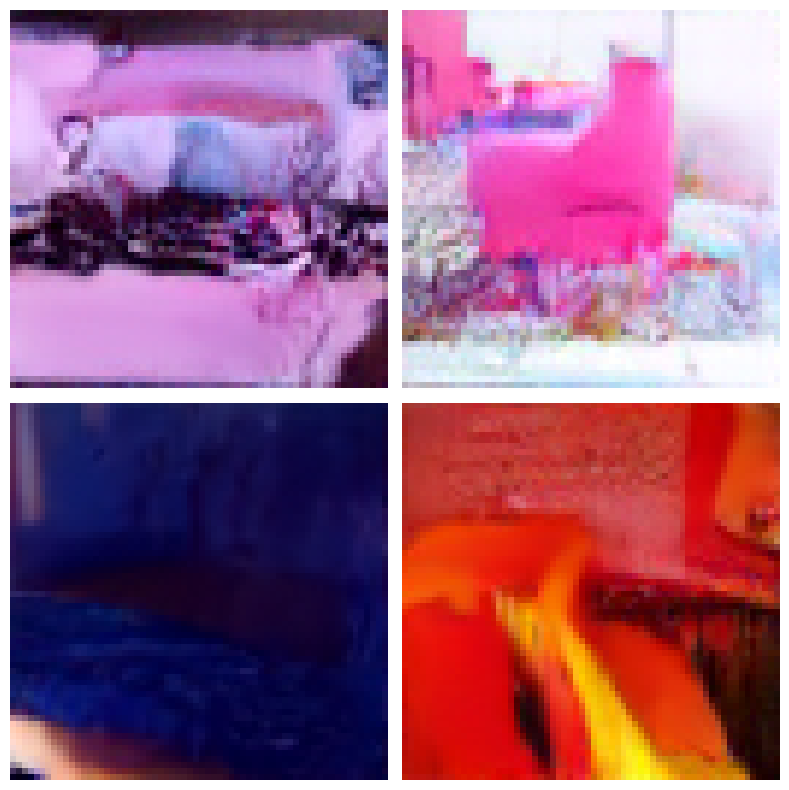

In [23]:
import matplotlib.pyplot as plt


def show_images(images, cols=2):
    rows = len(images) // cols + (1 if len(images) % cols != 0 else 0)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    for i, img in enumerate(images):
        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


# Show generated images
show_images(ims)

In [28]:
compute_fid(
    real_images=images_real, generated_images=[ims[0]], batch_size=32, device="cpu"
)

TypeError: 'Image' object is not iterable